In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr
import ast
from collections import Counter
from sklearn.linear_model import LogisticRegression
from scipy.stats import norm
import os
import seaborn as sns
from sklearn.decomposition import PCA

### Set Plotting style

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.rcParams.update({
    # 'figure.figsize': (3.35, 2.5),   # 单栏尺寸
    'font.family': 'Arial',
    'axes.labelsize': 7,
    'axes.titlesize': 8,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'legend.fontsize': 7,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.linewidth': 0.75,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.size': 2,
    'ytick.major.size': 2,
    'xtick.major.width': 0.5,
    'ytick.major.width': 0.5,
    'legend.loc': 'upper right'
})

### Task distribution

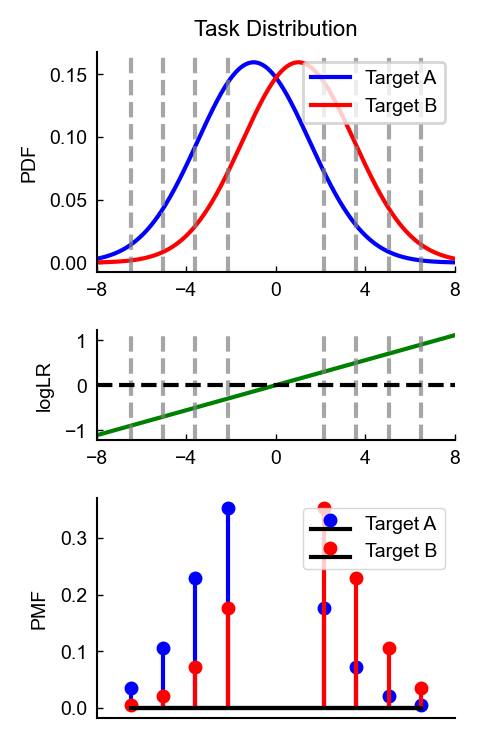

In [3]:
# Parameters for the symmetric Gaussians
mu = 1.0   # distance from y=0
sigma = 2.5
x = np.linspace(-8, 8, 500)

# Two symmetric Gaussian PDFs
pdf_left = norm.pdf(x, -mu, sigma)
pdf_right = norm.pdf(x, mu, sigma)

# Log ratio of PDFs
log_ratio = np.log10(pdf_right / pdf_left)

# Define target log ratio values
target_log_ratios = np.array([-0.9, -0.7, -0.5, -0.3, 0.3, 0.5, 0.7, 0.9])
# target_log_ratios = np.linspace(-0.9, 0.9, 8)

# Find corresponding x values by interpolation
x_targets = np.interp(target_log_ratios, log_ratio, x)

# Plot with vertical lines at target x values
fig, ax = plt.subplots(3, 1, figsize=(2.5, 3.8), gridspec_kw={'height_ratios': [2, 1, 2]})

pB_raw = norm.pdf(x_targets, mu, sigma)
pA_raw = norm.pdf(x_targets, -mu, sigma)

# Normalize
pB = pB_raw / pB_raw.sum()
pA = pA_raw / pA_raw.sum()

# Top plot: PDFs
ax[0].plot(x, pdf_left, label='Target A', color='blue')
ax[0].plot(x, pdf_right, label='Target B', color='red')
for xt in x_targets:
    ax[0].axvline(xt, color='gray', linestyle='--', alpha=0.7)
ax[0].set_xlim(-8, 8)
ax[0].set_xticks(range(-8, 9, 4))
# ax[0].set_xlabel('x')
ax[0].set_ylabel('PDF')
ax[0].legend()
ax[0].set_title('Task Distribution')

# middle plot: Log ratio
ax[1].plot(x, log_ratio, color='green')
for xt in x_targets:
    ax[1].axvline(xt, color='gray', linestyle='--', alpha=0.7)
ax[1].axhline(0, color='black', linestyle='--')
ax[1].set_xlim(-8, 8)
ax[1].set_xticks(range(-8, 9, 4))
# ax[1].set_xlabel('x')
ax[1].set_ylabel('logLR')

# bottom plot: Probability
markerline1, stemlines1, baseline1 = ax[2].stem(x_targets, pA, linefmt='b-', markerfmt='bo', basefmt='k-', label='Target A')
markerline2, stemlines2, baseline2 = ax[2].stem(x_targets, pB, linefmt='r-', markerfmt='ro', basefmt='k-', label='Target B')
markerline1.set_markersize(4)
markerline2.set_markersize(4)
ax[2].legend()
ax[2].set_xlim(-8, 8)
ax[2].set_xticks(range(-8, 9, 4))
# ax[2].set_ylim(0, 0.25)
ax[2].set_xlabel('x')
ax[2].set_ylabel('PMF')

# hide the xticks
ax[2].set_xticks([])
# hide the xlabel
ax[2].set_xlabel('')

leg2 = ax[2].get_legend()
leg2.get_frame().set_linewidth(0.5)
for lh in leg2.get_lines():
    lh.set_linewidth(1.0)
    lh.set_markersize(3.0)

plt.tight_layout()

# save the figure to svg
# plt.savefig('distribution.svg', dpi=300)

plt.show()

### Load the data
Add information to the dataframe:

In [77]:
root_path = '/Users/lijialin/Desktop/Research/SPRT/OriginalSPRT/results/'

path = root_path + 'exp_006_reward=1.0_sample_cost=0.01_urgency_cost=0.00_logLR=[-0.9,0.9]_max_samples=10_max_steps=10000_epNum=1500000/'

df= pd.read_json(path + 'data.json', lines=True)

# decision time
episode_lengths = df.groupby('episode').size().reset_index(name='decision_time')
df = df.merge(episode_lengths, on='episode', how='left')
df["decision_time"] = df["decision_time"] - 1
df["action"] = df["action"].astype(int)

# timesteps
df['time_step'] = df['stimuli_so_far'].apply(len)

# evidence
df["evidences"] = df.apply(lambda row: [target_log_ratios[s] for s in row["stimuli_so_far"][:row["decision_time"]]], axis=1)
df["evidence_sum"] = df["evidences"].apply(sum)

# policy
df['p_chooseA'] = df['policy'].apply(lambda p: p[0])
df['p_chooseB'] = df['policy'].apply(lambda p: p[1])
df['p_sample'] = df['policy'].apply(lambda p: p[2])
df['log_ratio'] = np.log10(df['p_chooseA'] / df['p_chooseB'].replace(0, np.nan)) # replace 0 with nan to avoid log(0)

# calculate the accuracy
correct_data = df[df["correct_answer"] == df["action"]].copy()

print('total correct trials:', len(correct_data))
correct_data_0 = correct_data[correct_data["correct_answer"] == 0]
correct_data_1 = correct_data[correct_data["correct_answer"] == 1]
print('correct trials for A:', len(correct_data_0))
print('correct trials for B:', len(correct_data_1))

df.head()
print(df.shape)

total correct trials: 47118
correct trials for A: 23472
correct trials for B: 23646
(325235, 16)


/Users/lijialin/miniconda3/envs/daily/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Basic Metrics

In [78]:
df_decision = df[df["action"] != 2].dropna(subset=["decision_time"])
df_decision.head()

,episode,correct_answer,stimuli_so_far,current_stimulus,action,reward,policy,hidden_state,decision_time,time_step,evidences,evidence_sum,p_chooseA,p_chooseB,p_sample,log_ratio
10,0,0,"[4, 7, 1, 5, 1, 2, 3, 5, 3, 1]",1,0,1.0,"[0.8602886200000001, 2.248e-07, 0.139711156500...","[-0.5713232756000001, 0.0875996202, 0.36388981...",10,10,"[0.3, 0.9, -0.7, 0.5, -0.7, -0.5, -0.3, 0.5, -...",-1.0,0.860289,2.248000e-07,0.139711,6.582848
17,1,0,"[2, 3, 4, 1, 4, 3]",3,0,1.0,"[0.4315666556, 1.9e-09, 0.5684333444]","[-0.38599976900000005, 0.20914070310000002, 0....",6,6,"[-0.5, -0.3, 0.3, -0.7, 0.3, -0.3]",-1.2,0.431567,1.900000e-09,0.568433,8.356294
24,2,0,"[3, 4, 3, 4, 2, 2]",2,0,1.0,"[0.2439712286, 1.05e-08, 0.7560287714]","[-0.38976383210000004, 0.19191473720000002, 0....",6,6,"[-0.3, 0.3, -0.3, 0.3, -0.5, -0.5]",-1.0,0.243971,1.050000e-08,0.756029,7.366149
29,3,0,"[1, 3, 2, 2]",2,0,1.0,"[0.8666226864000001, 0.0, 0.13337723910000002]","[-0.2929917574, 0.2526587844, 0.5127938986, 0....",4,4,"[-0.7, -0.3, -0.5, -0.5]",-2.0,0.866623,0.000000e+00,0.133377,NaN
38,4,0,"[5, 2, 6, 3, 3, 2, 3, 1]",1,0,1.0,"[0.8705724478, 8e-10, 0.12942755220000002]","[-0.4601238966, 0.1377509087, 0.44149339200000...",8,8,"[0.5, -0.5, 0.7, -0.3, -0.3, -0.5, -0.3, -0.7]",-1.4,0.870572,8.000000e-10,0.129428,9.036715


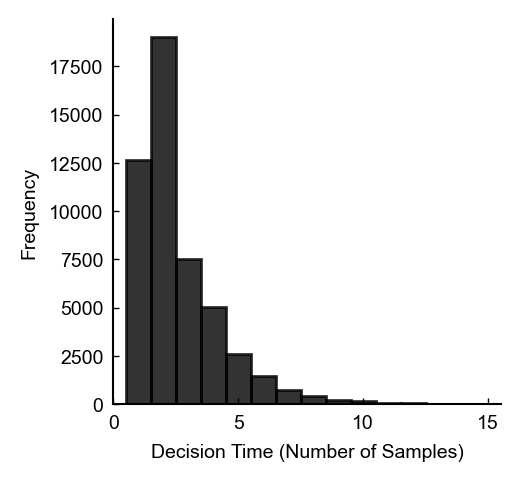

total trials: 50000
trials with decision time above 10: 161


In [74]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))

# histogram
ax.hist(df_decision["decision_time"], 
        bins=range(1, int(df_decision["decision_time"].max()) + 2),
        edgecolor='black', align='left', color = 'black', alpha = 0.8)
# ax.vlines(10, 0, 8000, color = 'red', linestyle = '--', linewidth = 0.5)
ax.set_xlabel("Decision Time (Number of Samples)")
ax.set_ylabel("Frequency")
# ax.set_title("Distribution of Decision Times")
ax.set_xlim(0, 15.5)
ax.set_xticks(range(0, 16, 5))
# ax.set_yticks(range(0, 8200, 2000))

# plt.savefig('dt_dist.svg', dpi=300)
plt.show()

# count how many trials decision time is above 10
print('total trials:', len(df_decision))
print('trials with decision time above 10:', len(df_decision[df_decision["decision_time"] > 10]))

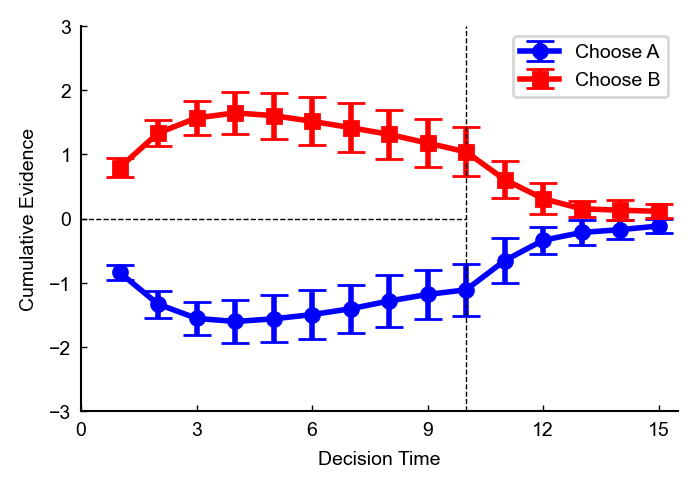

In [81]:
# remove trials when agent responded incorrectly
correct_data = df_decision[df_decision["correct_answer"] == df_decision["action"]].copy()

# separate into groups based on correct_answer value
correct_data_0 = correct_data[correct_data["correct_answer"] == 0]
correct_data_1 = correct_data[correct_data["correct_answer"] == 1]

grouped0_stats = correct_data_0.groupby("decision_time")["evidence_sum"].agg(["mean", "std", "count"])
grouped1_stats = correct_data_1.groupby("decision_time")["evidence_sum"].agg(["mean", "std", "count"])

# remove the decision time where the count is less than 5
# grouped0_stats = grouped0_stats[grouped0_stats["count"] >= 10]
# grouped1_stats = grouped1_stats[grouped1_stats["count"] >= 10]

# remove the decision time more than 20
grouped0_stats = grouped0_stats[grouped0_stats.index <= 15]
grouped1_stats = grouped1_stats[grouped1_stats.index <= 15]

grouped0_stats = grouped0_stats[grouped0_stats.index > 0]
grouped1_stats = grouped1_stats[grouped1_stats.index > 0]

# compute 95% confidence intervals
grouped0_stats["ci95"] = 1.96 * grouped0_stats["std"] / np.sqrt(grouped0_stats["count"])
grouped1_stats["ci95"] = 1.96 * grouped1_stats["std"] / np.sqrt(grouped1_stats["count"])

fig, ax = plt.subplots(figsize=(3.85, 2.5))
ax.errorbar(grouped0_stats.index, grouped0_stats["mean"], 
             yerr=grouped0_stats["std"], fmt='o-', capsize=5, label="Choose A", color='blue', markersize=5, elinewidth=2, linewidth=2)
ax.errorbar(grouped1_stats.index, grouped1_stats["mean"], 
             yerr=grouped1_stats["std"], fmt='s-', capsize=5, label="Choose B", color='red', markersize=5, elinewidth=2, linewidth=2)
ax.hlines(0, 0, 10, color='black', linestyle='--', linewidth=0.5)
ax.vlines(10, -3, 3, color = 'black', linestyle = '--', linewidth = 0.5)
ax.set_xlim(0, 15.5)
ax.set_xticks(range(0, 16, 3))
ax.set_ylim(-3, 3)
ax.set_xlabel("Decision Time")
ax.set_ylabel("Cumulative Evidence")
# ax.set_title("Decision Boundary vs Decision Time")
ax.legend()
# ax.grid(True)

plt.savefig('logLR_bound.svg', dpi=300)
plt.show()

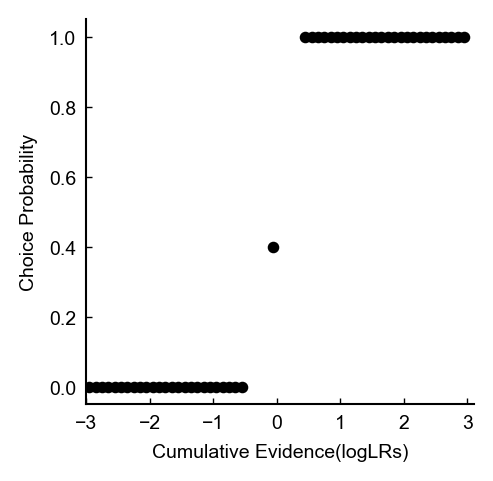

In [11]:
bin_width = 0.1
bin_start = -3
bin_end = 3.1

# psychometric_data = df_decision.groupby(['episode']).last().reset_index()
# # bin the evidence_sum
# psychometric_data["evidence_sum_binned"] = pd.cut(psychometric_data["evidence_sum"], 
#                                          bins=np.arange(bin_start, bin_end, bin_width), 
#                                          labels=np.arange(bin_start + bin_width/2, bin_end - bin_width/2, bin_width))

# psychometric_data = psychometric_data.groupby("evidence_sum_binned")["action"].mean().reset_index()
psychometric_data = df_decision.groupby(['episode'], sort=False).last().reset_index()

psychometric_data["evidence_sum_binned"] = pd.cut(
    psychometric_data["evidence_sum"],
    bins=np.arange(bin_start, bin_end, bin_width),
    labels=np.arange(bin_start + bin_width/2, bin_end - bin_width/2, bin_width),
    include_lowest=True,
)

psychometric_data = (
    psychometric_data
      .dropna(subset=["evidence_sum_binned"])
      .groupby("evidence_sum_binned", observed=True)["action"]
      .mean()
      .reset_index()
)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.scatter(psychometric_data["evidence_sum_binned"], psychometric_data["action"], s = 10, color = 'black')
ax.set_xlim(-3, 3.1)
ax.set_xticks(np.arange(-3, 3.1, 1))
ax.set_xlabel("Cumulative Evidence(logLRs)")
ax.set_ylabel("Choice Probability")
# ax.set_title("Choice Probability vs Accumulated Evidence")

plt.savefig('psychMetric.svg', dpi=300)
plt.show()

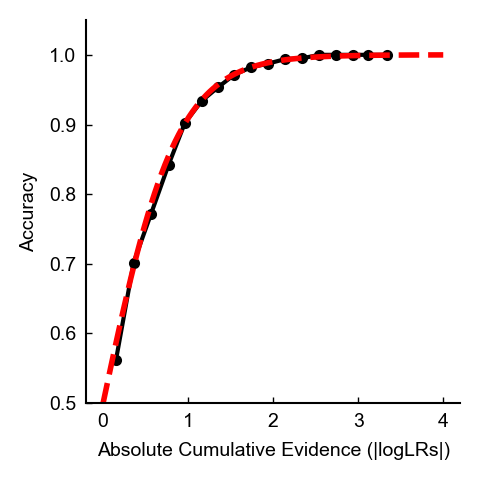

In [47]:
# Calculate accuracy for each row: 1 if action == correct_answer, else 0
df_decision["accuracy"] = (df_decision["action"] == df_decision["correct_answer"]).astype(float)

# Bin absolute cumulative evidence (logLRs)
bin_width = 0.2
abs_evidence = df_decision["evidence_sum"].abs()
bin_edges = np.arange(0, abs_evidence.max() + bin_width, bin_width)
bin_centers = bin_edges[:-1] + bin_width/2

df_decision["abs_evidence_bin"] = pd.cut(
    abs_evidence,
    bins=bin_edges,
    labels=bin_centers,
    include_lowest=False
)

# 计算每个abs_evidence_bin内logLRs（即evidence_sum的绝对值）的实际均值
mean_logLR_by_bin = (
    df_decision
      .dropna(subset=["abs_evidence_bin"])
      .groupby("abs_evidence_bin", observed=True)["evidence_sum"]
      .apply(lambda x: x.abs().mean())
      .reset_index()
      .rename(columns={"evidence_sum": "mean_abs_logLR"})
)

# 计算每个 bin 的 |logLR| 平均值（不 merge）
mean_map = (
    df_decision
      .dropna(subset=["abs_evidence_bin"])
      .groupby("abs_evidence_bin", observed=True)["evidence_sum"]
      .apply(lambda x: x.abs().mean())
)

# 直接映射到 df_decision，确保列一定存在
df_decision["mean_abs_logLR"] = df_decision["abs_evidence_bin"].map(mean_map)

# 后续聚合
accuracy_by_bin = (
    df_decision
      .dropna(subset=["mean_abs_logLR"])
      .groupby("mean_abs_logLR", observed=True)["accuracy"]
      .mean()
      .reset_index()
)


def theoretical_accuracy(x):
    return 1 / (1 + 10 ** (-x))

x = np.linspace(0, 4, 100)
y = theoretical_accuracy(x)
# Plot
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.plot(
    accuracy_by_bin["mean_abs_logLR"].astype(float),
    accuracy_by_bin["accuracy"],
    marker='o',
    color='black',
    linestyle='-',
    markersize=3
)
ax.plot(x, y, color='red', linestyle='--', linewidth=2)
ax.set_xlabel("Absolute Cumulative Evidence (|logLRs|)")
ax.set_ylabel("Accuracy")
# ax.set_title("Accuracy vs. |Cumulative Evidence|")

# ax.set_xlim(0, 3.1)
# ax.set_xticks(np.arange(0, 3.1, 1))
ax.set_ylim(0.5, 1.05)
ax.set_yticks(np.arange(0.5, 1.05, 0.1))

plt.tight_layout()
plt.savefig('accuracy_vs_abs_logLR.svg', dpi=300)
plt.show()

Logistic regression: subjective weights assigned to each stimulus
$$
P(choose \ A) = \frac{1}{1 + e^{-Q}}
$$
where
$$
Q = \sum_{i=1}^8 \beta_i n_i
$$
$n_i$ is the number of times the stimulus is presented in each trial

In [48]:
df_last = df.groupby("episode").last()
stimuli_counts = df_last["stimuli_so_far"].apply(Counter)
stimuli_df = pd.DataFrame.from_records(stimuli_counts).fillna(0).astype(int)

stimuli_df = stimuli_df[sorted(stimuli_df.columns)]
stimuli_df["action"] = df_last["action"]

stimuli_df.head()

,0,1,2,3,4,5,6,7,action
0,0,3,1,2,1,2,0,1,0
1,0,1,1,2,2,0,0,0,0
2,0,0,2,2,2,0,0,0,0
3,0,1,2,1,0,0,0,0,0
4,0,1,2,3,0,1,1,0,0


In [49]:
# X is the features, y is the target
X = stimuli_df.drop(columns=['action'])
y = stimuli_df['action']

# fit the logistic regression model
model = LogisticRegression()
model.fit(X, y)

# get the coefficients and intercept
coef_natural = pd.Series(model.coef_[0], index=X.columns)
intercept_natural = model.intercept_[0]

# sort the coefficients by stimulus value
coef_natural = coef_natural.sort_index()


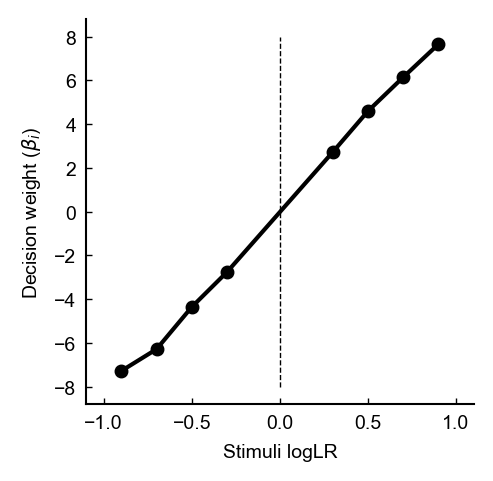

In [50]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.plot(target_log_ratios, coef_natural, 'o-', color = 'black', markersize = 4)
ax.vlines(0, -8, 8, color='black', linestyle='--', linewidth = 0.5)
ax.set_xlim(-1.1, 1.1)
ax.set_xticks(np.arange(-1.0, 1.1, 0.5))
ax.set_xlabel("Stimuli logLR")
ax.set_ylabel(r"Decision weight ($\beta_i$)")
# ax.set_title("Subjective Weights of stimulus")
# ax.grid(True)

plt.savefig('subjWeight.svg', dpi=300)
plt.show()

## Model policy

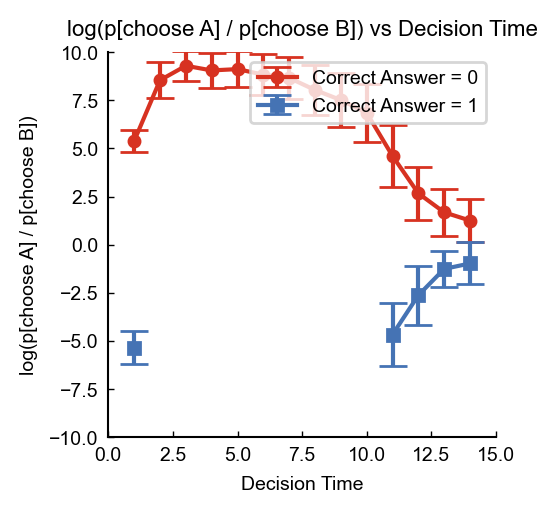

In [275]:
grouped0_stats = correct_data_0.groupby("decision_time")["log_ratio"].agg(["mean", "std", "count"])
grouped1_stats = correct_data_1.groupby("decision_time")["log_ratio"].agg(["mean", "std", "count"])

# remove the decision time where the count is less than 5
grouped0_stats = grouped0_stats[grouped0_stats["count"] >= 10]
grouped1_stats = grouped1_stats[grouped1_stats["count"] >= 10]

grouped0_stats = grouped0_stats[grouped0_stats.index <= 20]
grouped1_stats = grouped1_stats[grouped1_stats.index <= 20]

# plot the mean of log_ratio vs decision_time
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.errorbar(grouped0_stats.index, grouped0_stats["mean"], 
             yerr=grouped0_stats["std"], fmt='o-', capsize=5, label="Correct Answer = 0", color='#d73221', markersize = 4)
ax.errorbar(grouped1_stats.index, grouped1_stats["mean"], 
             yerr=grouped1_stats["std"], fmt='s-', capsize=5, label="Correct Answer = 1", color='#4573b4', markersize = 4)
ax.set_xlabel("Decision Time")
ax.set_ylabel("log(p[choose A] / p[choose B])")
ax.set_title("log(p[choose A] / p[choose B]) vs Decision Time")
ax.set_ylim(-10, 10)
ax.set_xlim(0, 15)
ax.legend()
plt.show()

### Decision weight on each timestep
To examine the effect of how RNNs learn to integrate cues over time, we conduct the following logistic regression:
$$
\text{logit}(P(\text{choose B})) = \beta_0 + \sum_{t=1}^{T} \beta_t \cdot \text{logLR}_t
$$

In [51]:
df_decision.head()
decision_times = sorted(df_decision['decision_time'].unique())

# Store results
results = {}

for dt in decision_times:

    if dt > 15:
        continue
    
    # Filter data for this decision time
    dt_data = df_decision[df_decision['decision_time'] == dt].copy()
    
    if len(dt_data) < 10:  # Skip if too few samples
        print(f"  Skipping decision_time {dt}: insufficient data ({len(dt_data)} samples)")
        continue
        
    # Create feature matrix: each column represents a position in the sequence
    X = np.stack(dt_data['evidences'].values)
    y = np.where(dt_data['action'].values == 1, 1, 0)

    if X.shape[1] == 0:
        print(f"  Skipping decision_time {dt}: empty evidence sequences")
        continue
    
    # Check if we have variation in the target variable
    if len(np.unique(y)) < 2:
        print(f"  Skipping decision_time {dt}: no variation in decisions")
        continue
        
    # Fit logistic regression
    model = LogisticRegression(fit_intercept=True, max_iter=2000)
    model.fit(X, y)
    
    # Store results
    results[dt] = {
        'coefficients': model.coef_[0],
        'intercept': model.intercept_[0],
        'n_samples': len(dt_data),
        'positions': list(range(1, dt + 1)),
        'accuracy': model.score(X, y)
    }

  Skipping decision_time 0: insufficient data (9 samples)


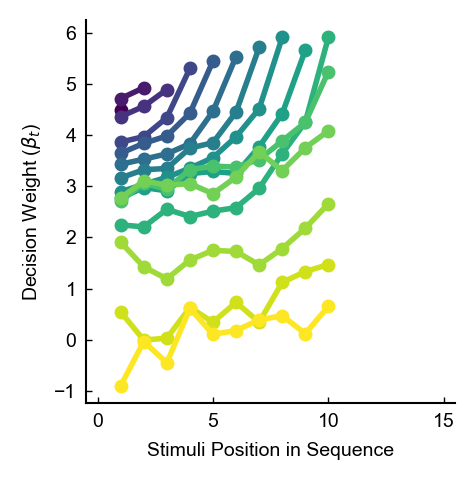

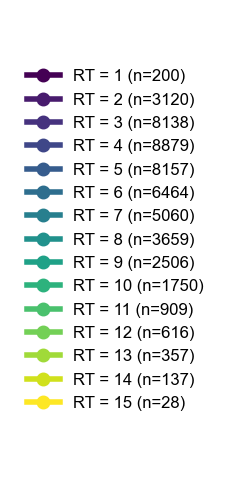

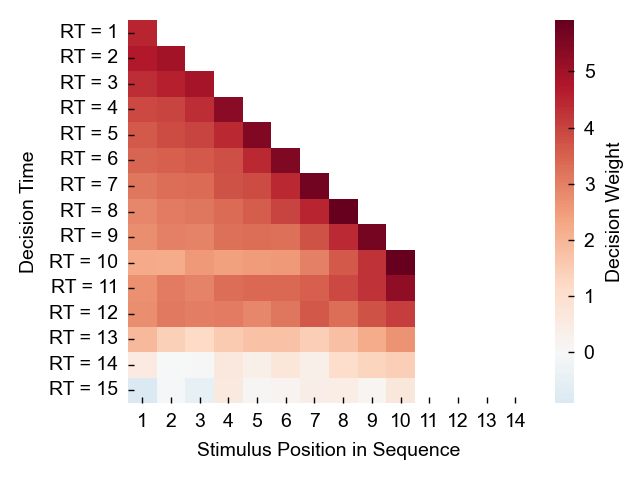

In [52]:
def plot_decision_weights(results):
    """Plot decision weights as a function of cue position for different decision times"""
    
    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    colors = plt.cm.viridis(np.linspace(0, 1, len(results)))
    max_position = 0
    handles = []
    labels = []
    
    for i, (dt, data) in enumerate(results.items()):
        positions = np.array(data['positions'])
        weights = np.array(data['coefficients'])
        
        min_len = min(len(positions), len(weights))
        positions = positions[:min_len]
        weights = weights[:min_len]
        
        line, = ax.plot(positions, weights, 'o-', color=colors[i], 
                        label=f'RT = {dt} (n={data["n_samples"]})', 
                        linewidth=2, markersize=4)
        handles.append(line)
        labels.append(f'RT = {dt} (n={data["n_samples"]})')
        
        max_position = max(max_position, max(positions))
    
    ax.set_xlabel('Stimuli Position in Sequence')
    ax.set_ylabel(r'Decision Weight ($\beta_t$)')
    ax.set_xticks(np.arange(0, 16, 5))
    ax.set_xlim(-0.5, 15.5)
    plt.tight_layout()

    plt.savefig('decisionWeights_softBound.svg', dpi=300)
    plt.show()
    
    # ---- plot legend separately ----
    fig_leg = plt.figure(figsize=(1, 2.5))
    fig_leg.legend(handles, labels, loc='center', frameon=False, fontsize=6)
    plt.axis('off')
    plt.tight_layout()

    plt.savefig('decisionWeights_legend_inf.svg', dpi=300)
    plt.show()

def plot_decision_weights_heatmap(results):
    """Create a heatmap showing decision weights across positions and decision times"""
    
    # Determine the maximum position across all decision times
    max_position = max(max(data['positions']) for data in results.values()) + 1
    decision_times = sorted(results.keys())
    
    # Create matrix for heatmap
    weight_matrix = np.full((len(decision_times), max_position), np.nan)
    
    for i, dt in enumerate(decision_times):    
        if dt in results:
            positions = results[dt]['positions']
            weights = results[dt]['coefficients']
            for pos, weight in zip(positions, weights):
                weight_matrix[i, pos] = weight
    
    # Create heatmap
    fig, ax = plt.subplots(figsize=(3.35, 2.5))
    
    # Create mask for missing values
    mask = np.isnan(weight_matrix)
    
    sns.heatmap(weight_matrix, 
                xticklabels=range(max_position),
                yticklabels=[f'RT = {dt}' for dt in decision_times],
                cmap='RdBu_r', center=0, 
                annot=False, fmt='.2f',
                mask=mask,
                cbar_kws={'label': 'Decision Weight'})
    
    ax.set_xlabel('Stimulus Position in Sequence')
    ax.set_ylabel('Decision Time')
    ax.set_xlim(1, 15)
    # plt.title('Decision Weights Heatmap: Position × Decision Time', fontsize=14)
    plt.tight_layout()

    # plt.savefig('decisionWeights_heatmap_inf.svg', dpi=300)
    plt.show()

fig1 = plot_decision_weights(results)
fig2 = plot_decision_weights_heatmap(results)

## Hidden States

PCA

In [322]:
df.shape

(254991, 16)

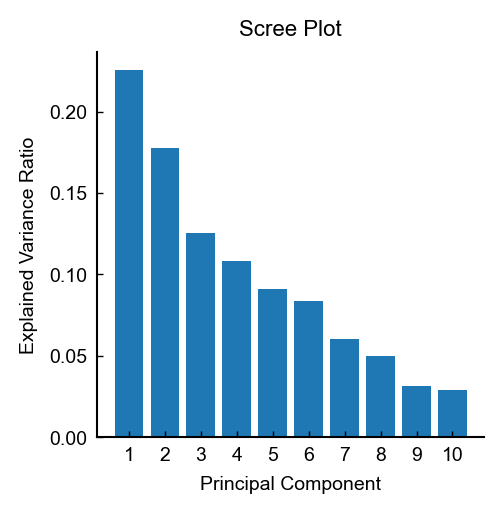

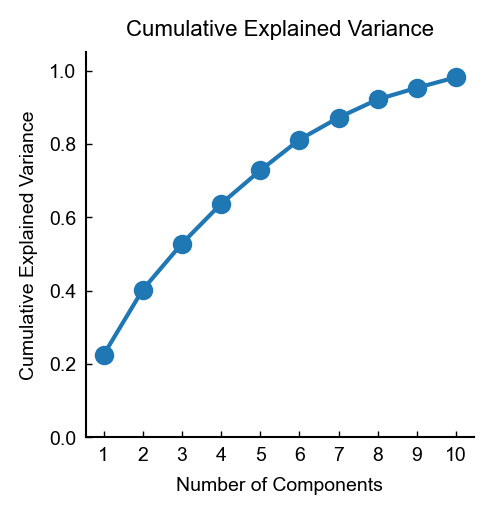

In [229]:
D = len(df.hidden_state.iloc[0])
hmat = np.vstack(df.hidden_state.values)
pca_full = PCA(n_components=10)
pca_full.fit(X)

ratios = pca_full.explained_variance_ratio_

# ---- Scree plot ----
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.bar(np.arange(1, 10 + 1), ratios[:10], align='center')
ax.set_xlabel("Principal Component")
ax.set_ylabel("Explained Variance Ratio")
plt.title("Scree Plot")
plt.xticks(np.arange(1, 10 + 1))
plt.show()

# ---- Cumulative explained variance ----
cum_ratios = np.cumsum(ratios)
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.plot(np.arange(1, 10 + 1), cum_ratios[:10], marker='o')
ax.set_xlabel("Number of Components")
ax.set_ylabel("Cumulative Explained Variance")
ax.set_title("Cumulative Explained Variance")
ax.set_xticks(np.arange(1, 10 + 1))
ax.set_ylim(0,1.05)
plt.show()

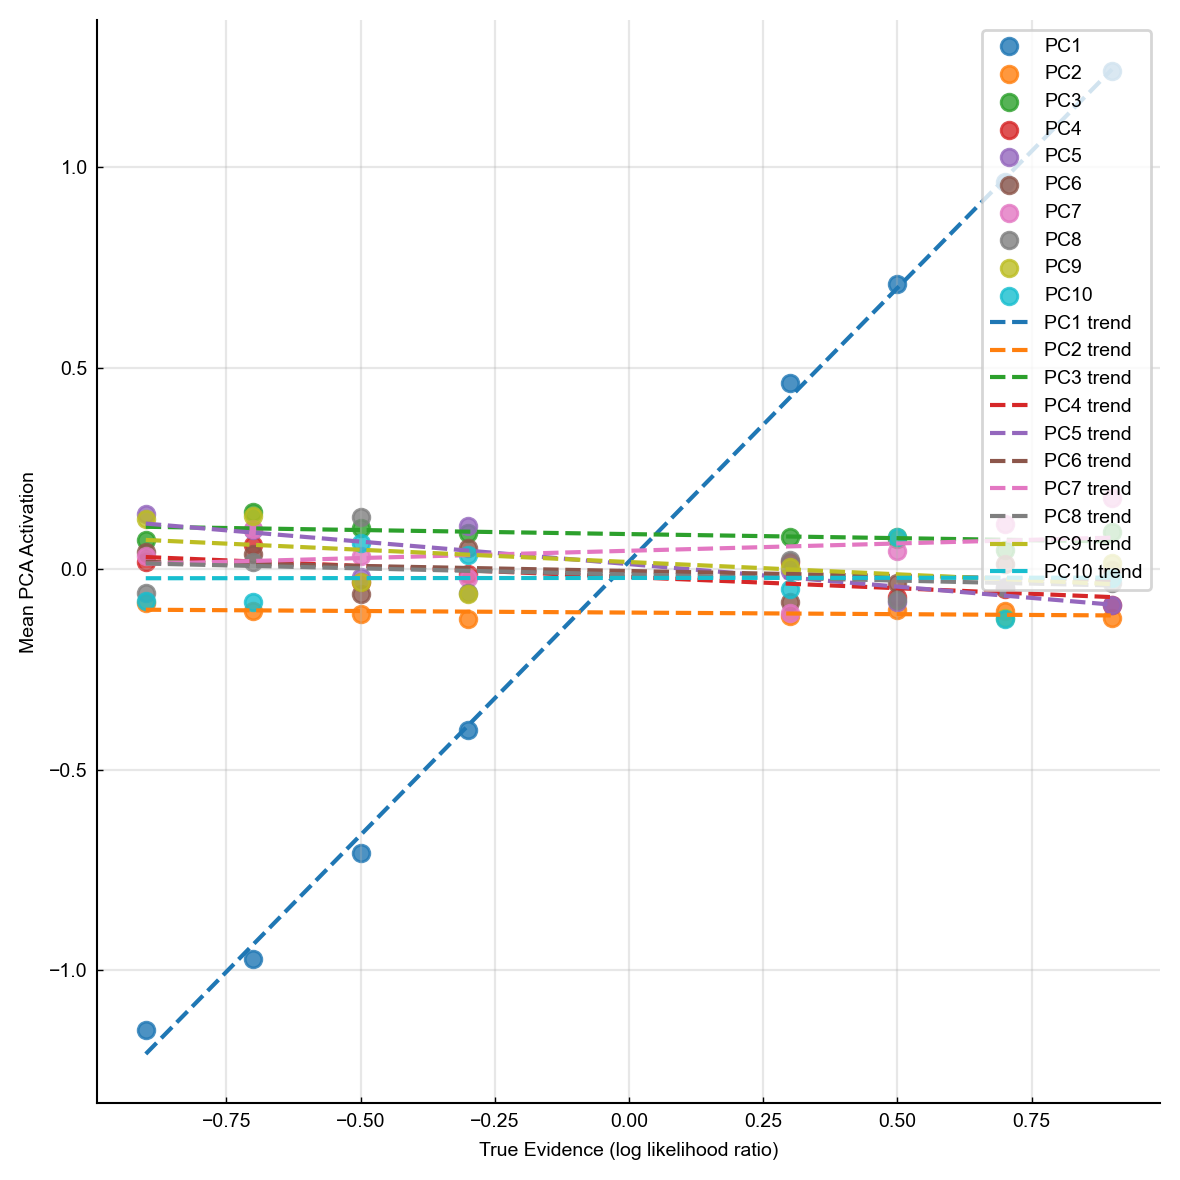

In [329]:
X = hmat  # shape (n_samples, D)
pca = PCA(n_components=10)
Z = pca.fit_transform(X)

df[['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'PCA6', 'PCA7', 'PCA8', 'PCA9', 'PCA10']] = Z

df_remove0 = df[df['time_step'] != 0]

# Compute average PCA activations grouped by stimulus
grouped = df_remove0.groupby('current_stimulus')[['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'PCA6', 'PCA7', 'PCA8', 'PCA9', 'PCA10']].mean().reset_index()

# Get corresponding logLR evidence values
logLRs = target_log_ratios[grouped['current_stimulus'].astype(int).values]

# Plot
plt.figure(figsize=(6, 6))

plt.scatter(logLRs, grouped['PCA1'], label='PC1', alpha=0.8)
plt.scatter(logLRs, grouped['PCA2'], label='PC2', alpha=0.8)
plt.scatter(logLRs, grouped['PCA3'], label='PC3', alpha=0.8)
plt.scatter(logLRs, grouped['PCA4'], label='PC4', alpha=0.8)
plt.scatter(logLRs, grouped['PCA5'], label='PC5', alpha=0.8)
plt.scatter(logLRs, grouped['PCA6'], label='PC6', alpha=0.8)
plt.scatter(logLRs, grouped['PCA7'], label='PC7', alpha=0.8)
plt.scatter(logLRs, grouped['PCA8'], label='PC8', alpha=0.8)
plt.scatter(logLRs, grouped['PCA9'], label='PC9', alpha=0.8)
plt.scatter(logLRs, grouped['PCA10'], label='PC10', alpha=0.8)

# Optional: fit and plot trend lines
for yvals, label in zip([grouped['PCA1'], grouped['PCA2'], grouped['PCA3'], grouped['PCA4'], grouped['PCA5'], grouped['PCA6'], grouped['PCA7'], grouped['PCA8'], grouped['PCA9'], grouped['PCA10']], ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']):
    z = np.polyfit(logLRs, yvals, 1)
    p = np.poly1d(z)
    x_line = np.linspace(logLRs.min(), logLRs.max(), 100)
    plt.plot(x_line, p(x_line), "--", label=f"{label} trend")

plt.xlabel('True Evidence (log likelihood ratio)')
plt.ylabel('Mean PCA Activation')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

/var/folders/j5/y5g6mhcd7wg0lg4_wsdrql7r0000gn/T/ipykernel_3115/2463886152.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_remove0.groupby('evidence_bin')[['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'PCA6', 'PCA7', 'PCA8', 'PCA9', 'PCA10']].mean()
/var/folders/j5/y5g6mhcd7wg0lg4_wsdrql7r0000gn/T/ipykernel_3115/2463886152.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_centers = df_remove0.groupby('evidence_bin')['evidence_sum'].mean()


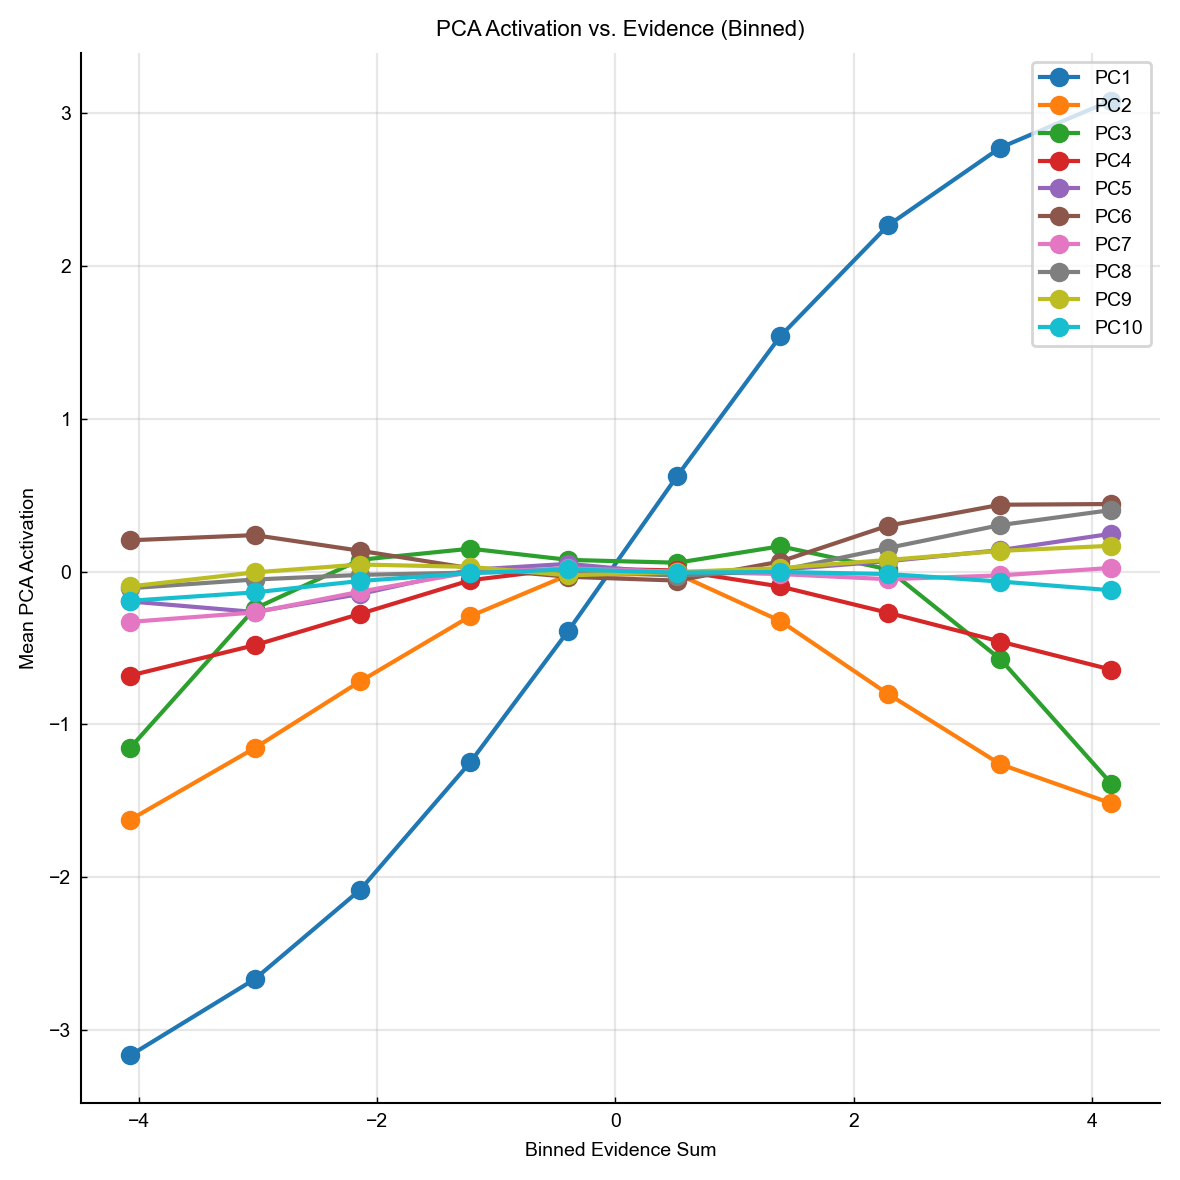

In [330]:
X = hmat  # shape (n_samples, D)
pca = PCA(n_components=10)
Z = pca.fit_transform(X)

df[['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'PCA6', 'PCA7', 'PCA8', 'PCA9', 'PCA10']] = Z

# Step 2: Remove time_step == 0
df_remove0 = df[df['time_step'] != 0].copy()

# Step 3: Bin evidence_sum (you can change `n_bins` or use qcut for quantiles)
n_bins = 10
df_remove0['evidence_bin'] = pd.cut(df_remove0['evidence_sum'], bins=n_bins)

# Step 4: Group by bins and average PCA activations
grouped = df_remove0.groupby('evidence_bin')[['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'PCA6', 'PCA7', 'PCA8', 'PCA9', 'PCA10']].mean()

# Compute bin centers for plotting on x-axis
bin_centers = df_remove0.groupby('evidence_bin')['evidence_sum'].mean()

# Step 5: Plot
plt.figure(figsize=(6, 6))

plt.plot(bin_centers, grouped['PCA1'], label='PC1', marker='o')
plt.plot(bin_centers, grouped['PCA2'], label='PC2', marker='o')
plt.plot(bin_centers, grouped['PCA3'], label='PC3', marker='o')
plt.plot(bin_centers, grouped['PCA4'], label='PC4', marker='o')
plt.plot(bin_centers, grouped['PCA5'], label='PC5', marker='o')
plt.plot(bin_centers, grouped['PCA6'], label='PC6', marker='o')
plt.plot(bin_centers, grouped['PCA7'], label='PC7', marker='o')
plt.plot(bin_centers, grouped['PCA8'], label='PC8', marker='o')
plt.plot(bin_centers, grouped['PCA9'], label='PC9', marker='o')
plt.plot(bin_centers, grouped['PCA10'], label='PC10', marker='o')

plt.xlabel('Binned Evidence Sum')
plt.ylabel('Mean PCA Activation')
plt.title('PCA Activation vs. Evidence (Binned)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

/Users/lijialin/miniconda3/envs/daily/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:557: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/lijialin/miniconda3/envs/daily/lib/python3.10/site-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/lijialin/miniconda3/envs/daily/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/lijialin/miniconda3/envs/daily/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/lijialin/miniconda3/envs/daily/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


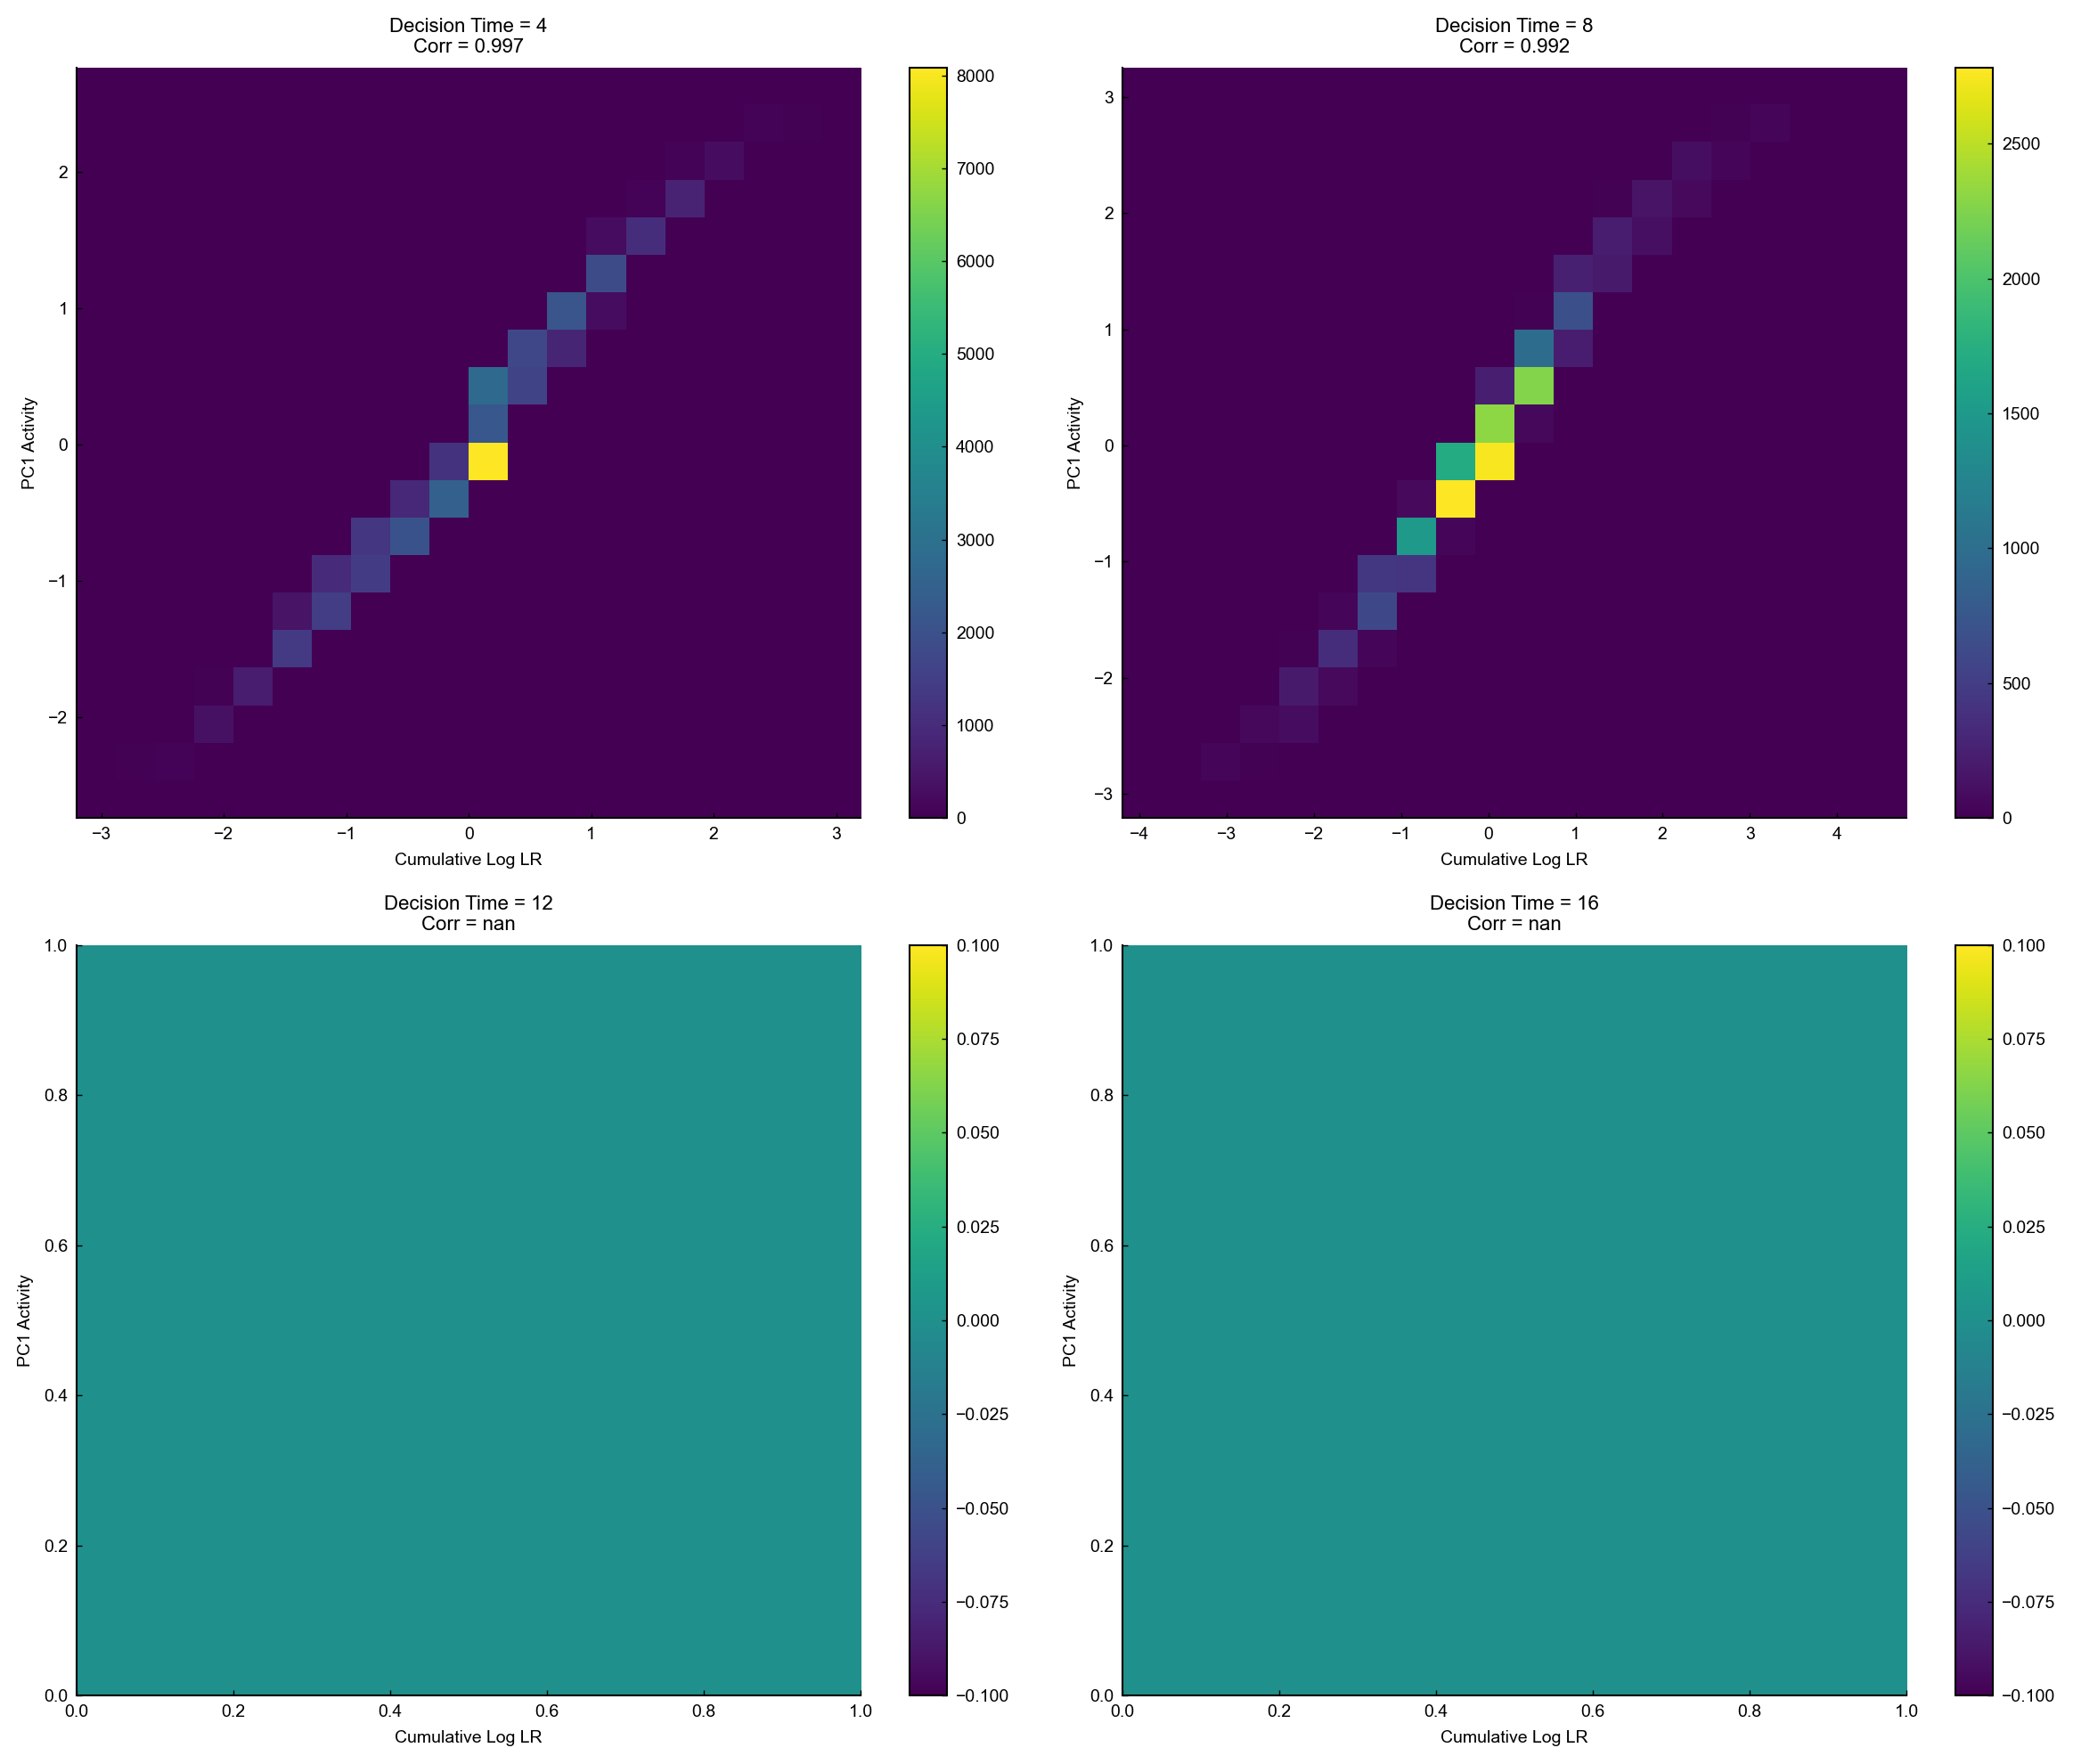

In [331]:
# Create figure with 3 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Decision times to analyze
decision_times = [4, 8, 12, 16]

for idx, dt in enumerate(decision_times):
    # Filter data for this decision time
    dt_data = df[df['decision_time'] == dt]
    
    # Create 2D histogram
    hist, xedges, yedges = np.histogram2d(
        dt_data['evidence_sum'],
        dt_data['PCA1'],
        bins=20
    )
    
    # Calculate correlation coefficient
    corr = np.corrcoef(dt_data['evidence_sum'], dt_data['PCA1'])[0,1]
    
    # Create heatmap
    im = axes[idx].imshow(hist.T, 
                         origin='lower',
                         aspect='auto',
                         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                         cmap='viridis')
    
    axes[idx].set_xlabel('Cumulative Log LR')
    axes[idx].set_ylabel('PC1 Activity')
    axes[idx].set_title(f'Decision Time = {dt}\nCorr = {corr:.3f}')
    
    # Add colorbar
    plt.colorbar(im, ax=axes[idx])

plt.tight_layout()
plt.show()

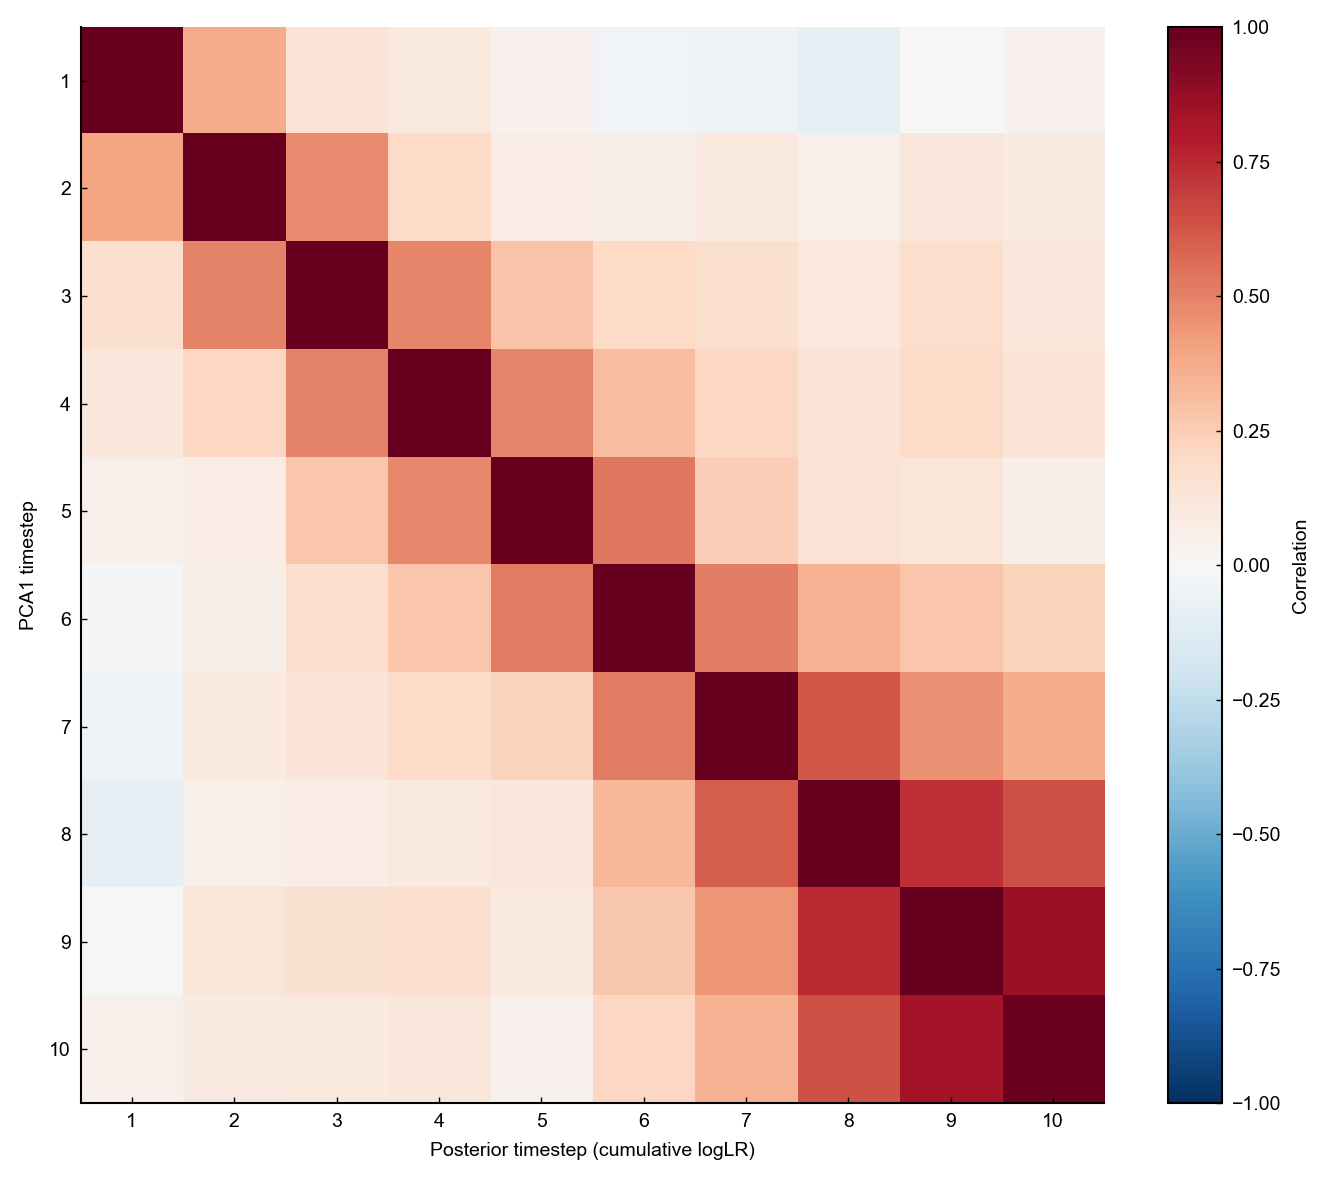

In [333]:
def plot_pc1_loglr_timestep_correlation(df, decision_time=10, pc_col='PCA1', loglr_col='evidence_sum', time_col='time_step'):
    """
    Plots a heatmap of correlations between PC1 activity and cumulative logLR
    across all timestep pairs for trials with a fixed decision time.

    Parameters:
    - df: pandas DataFrame containing PCA and logLR data
    - decision_time: the fixed decision time to filter trials (default: 10)
    - pc_col: the name of the PCA column to correlate (default: 'PCA1')
    - loglr_col: the name of the logLR column (default: 'evidence_sum')
    - time_col: the name of the time step column (default: 'time_step')
    """
    
    # Filter data for the specified decision time
    df_filtered = df[df['decision_time'] == decision_time].copy()
    max_timestep = df_filtered[time_col].max()

    # Initialize correlation matrix
    corr_matrix = np.zeros((max_timestep, max_timestep))

    # Compute correlations between PC1 and logLR across all timestep pairs
    for i in range(1, max_timestep + 1):  # PC1 timestep
        pca_data = df_filtered[df_filtered[time_col] == i][pc_col]
        
        for j in range(1, max_timestep + 1):  # logLR timestep
            lr_data = df_filtered[df_filtered[time_col] == j][loglr_col]
            
            # Only compute if both have data
            if len(pca_data) > 0 and len(lr_data) > 0:
                corr = np.corrcoef(pca_data, lr_data)[0, 1]
                corr_matrix[i - 1, j - 1] = corr

    # Plot heatmap
    plt.figure(figsize=(7, 6))
    im = plt.imshow(corr_matrix, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
    plt.colorbar(im, label='Correlation')

    plt.xlabel('Posterior timestep (cumulative logLR)')
    plt.ylabel(f'{pc_col} timestep')
    plt.xticks(range(max_timestep), range(1, max_timestep + 1))
    plt.yticks(range(max_timestep), range(1, max_timestep + 1))

    plt.tight_layout()
    plt.show()

plot_pc1_loglr_timestep_correlation(df, decision_time=10)

(8976, 26)
(29076, 26)
(36576, 26)
(39195, 26)
(36414, 26)
(31353, 26)
(24880, 26)
(19341, 26)
(25200, 26)
(3817, 26)


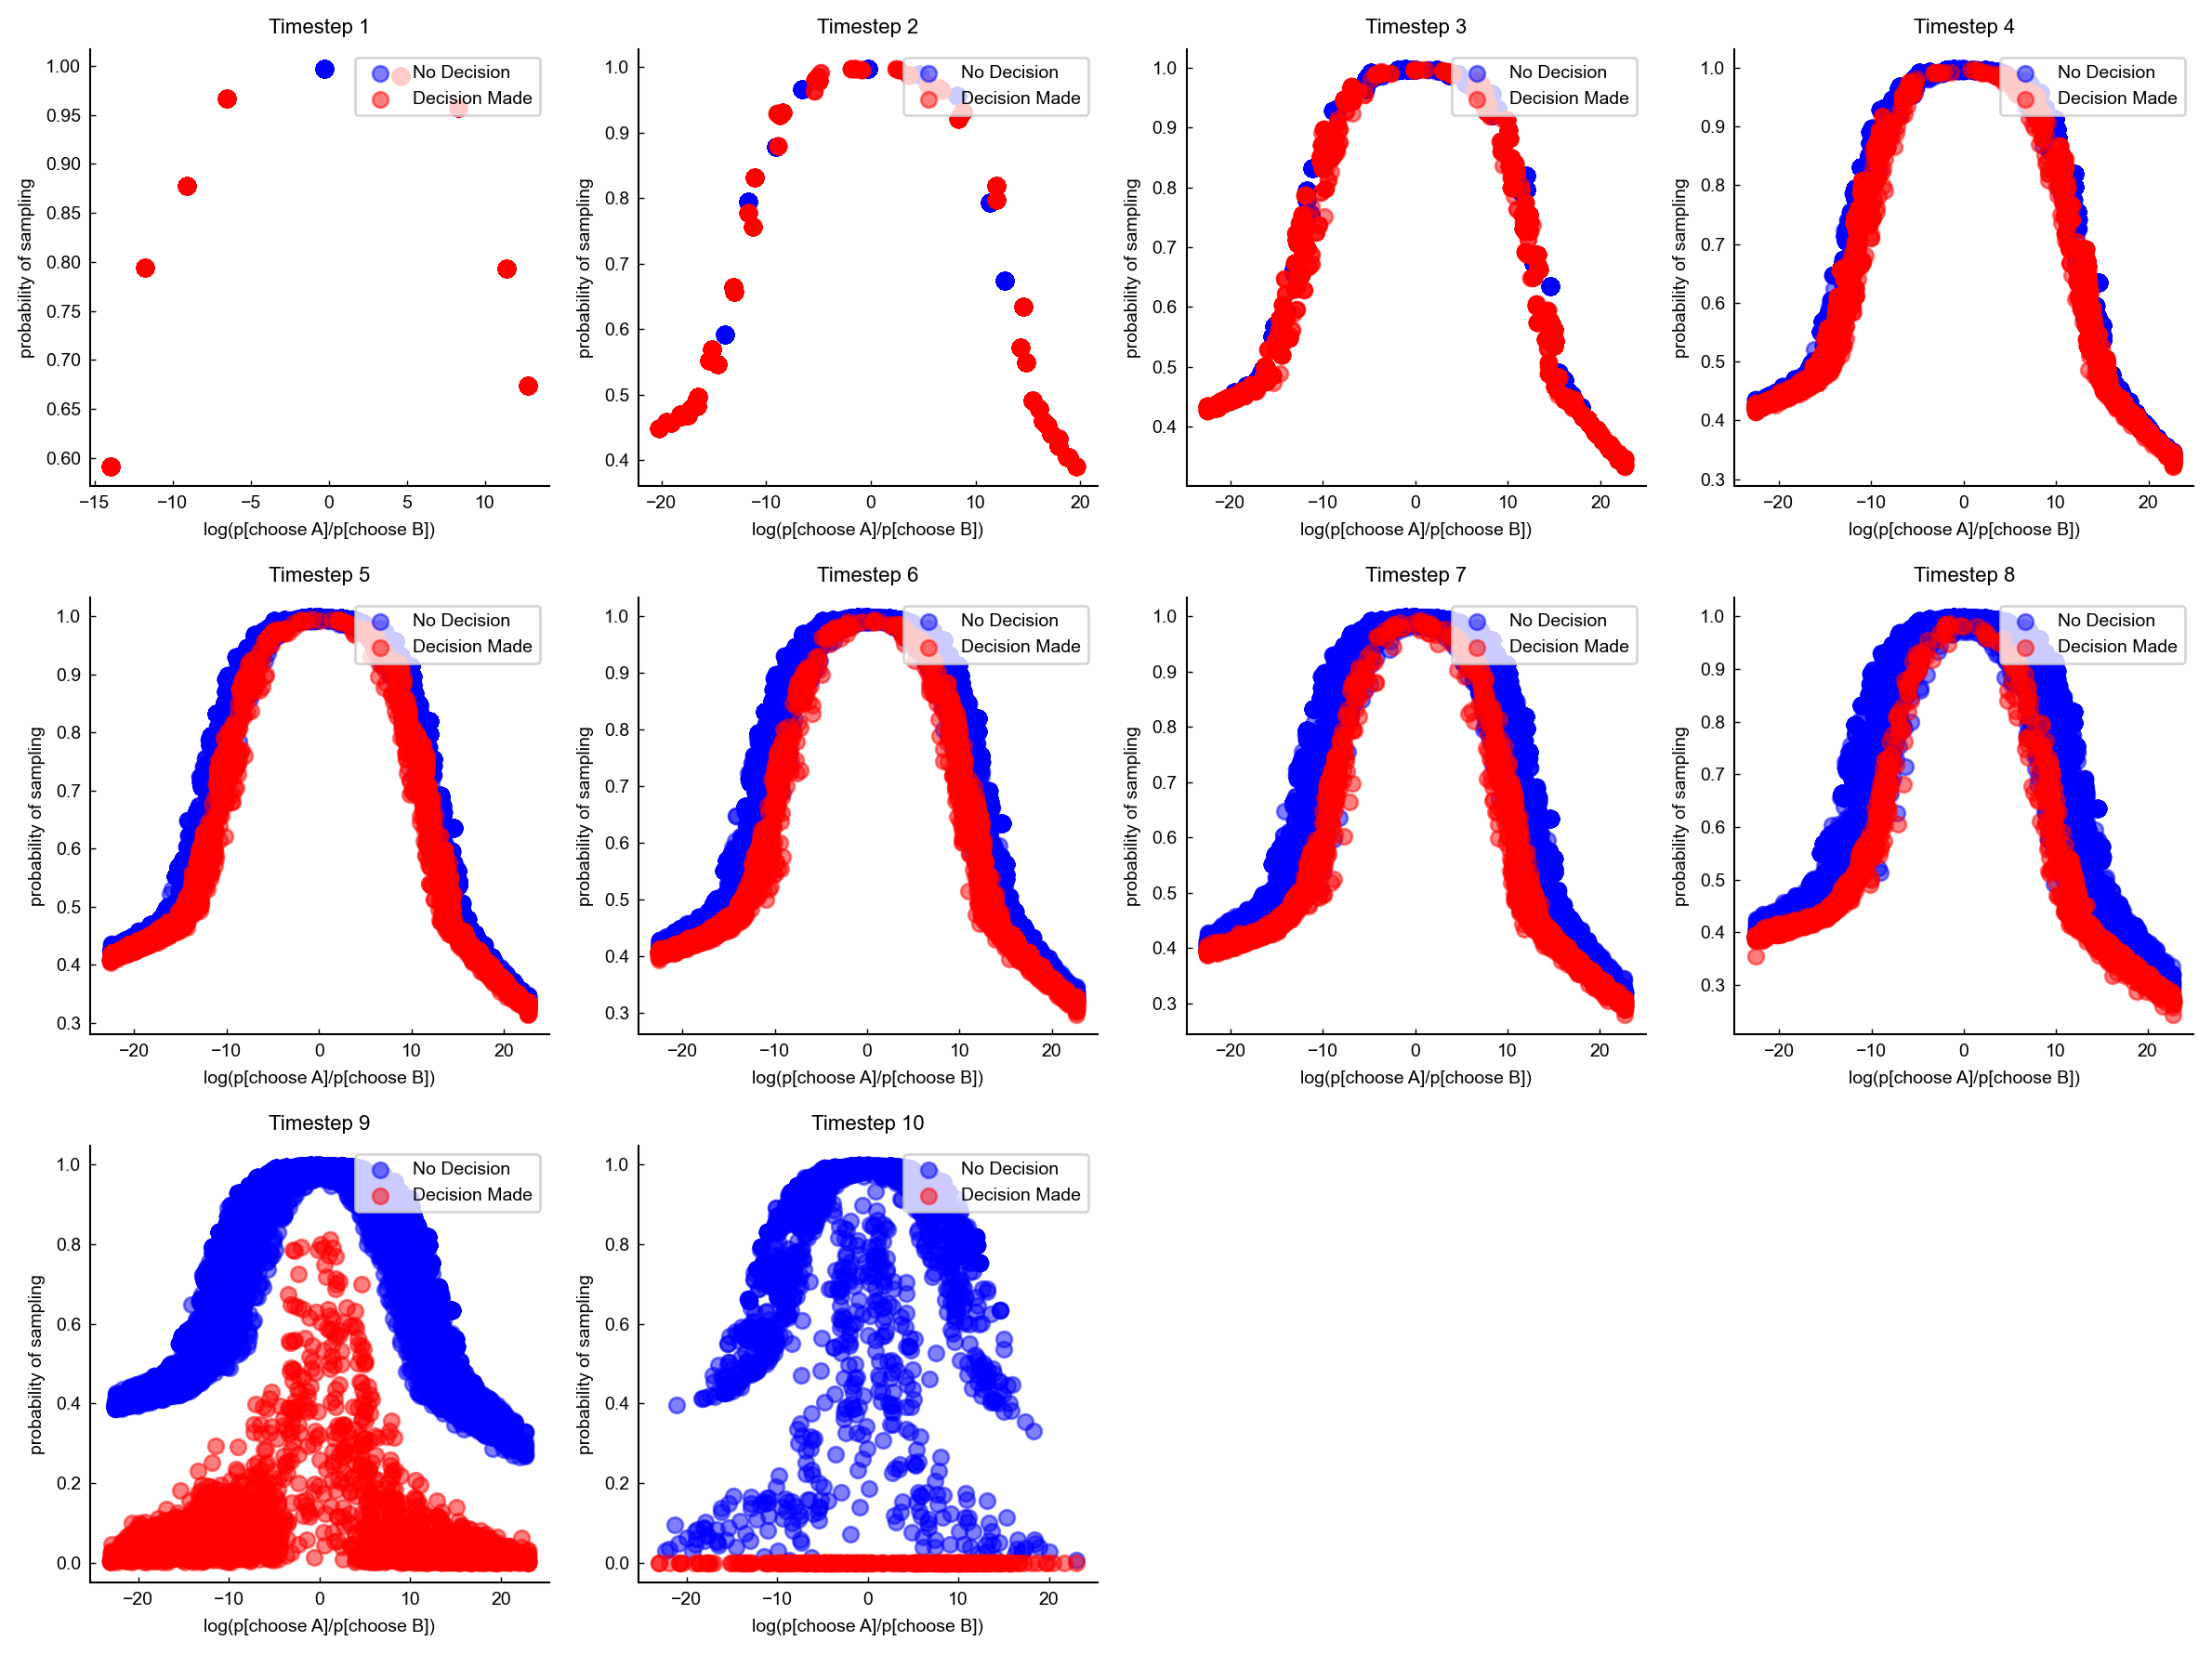

In [334]:
max_timestep = 10
n_rows = int(np.ceil(max_timestep/4))
fig, axes = plt.subplots(n_rows, 4, figsize=(12, 3*n_rows))
axes = axes.flatten()

# Plot scatter for each timestep
for t in range(max_timestep):
    if t < len(axes):
        # Get data for this timestep
        mask = df['decision_time'] == t+1
        timestep_data = df[mask]

        print(np.shape(timestep_data))
        
        # Create decision mask
        decision_mask = timestep_data['action'] < 2
        
        # Plot scatter points
        axes[t].scatter(timestep_data[~decision_mask]['log_ratio'], 
                       timestep_data[~decision_mask]['p_sample'],
                       c='blue', alpha=0.5, label='No Decision')
        axes[t].scatter(timestep_data[decision_mask]['log_ratio'],
                       timestep_data[decision_mask]['p_sample'], 
                       c='red', alpha=0.5, label='Decision Made')
        
        axes[t].set_title(f'Timestep {t + 1}')
        axes[t].set_xlabel('log(p[choose A]/p[choose B])')
        axes[t].set_ylabel('probability of sampling')
        axes[t].legend()

# Remove empty subplots
for i in range(max_timestep, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

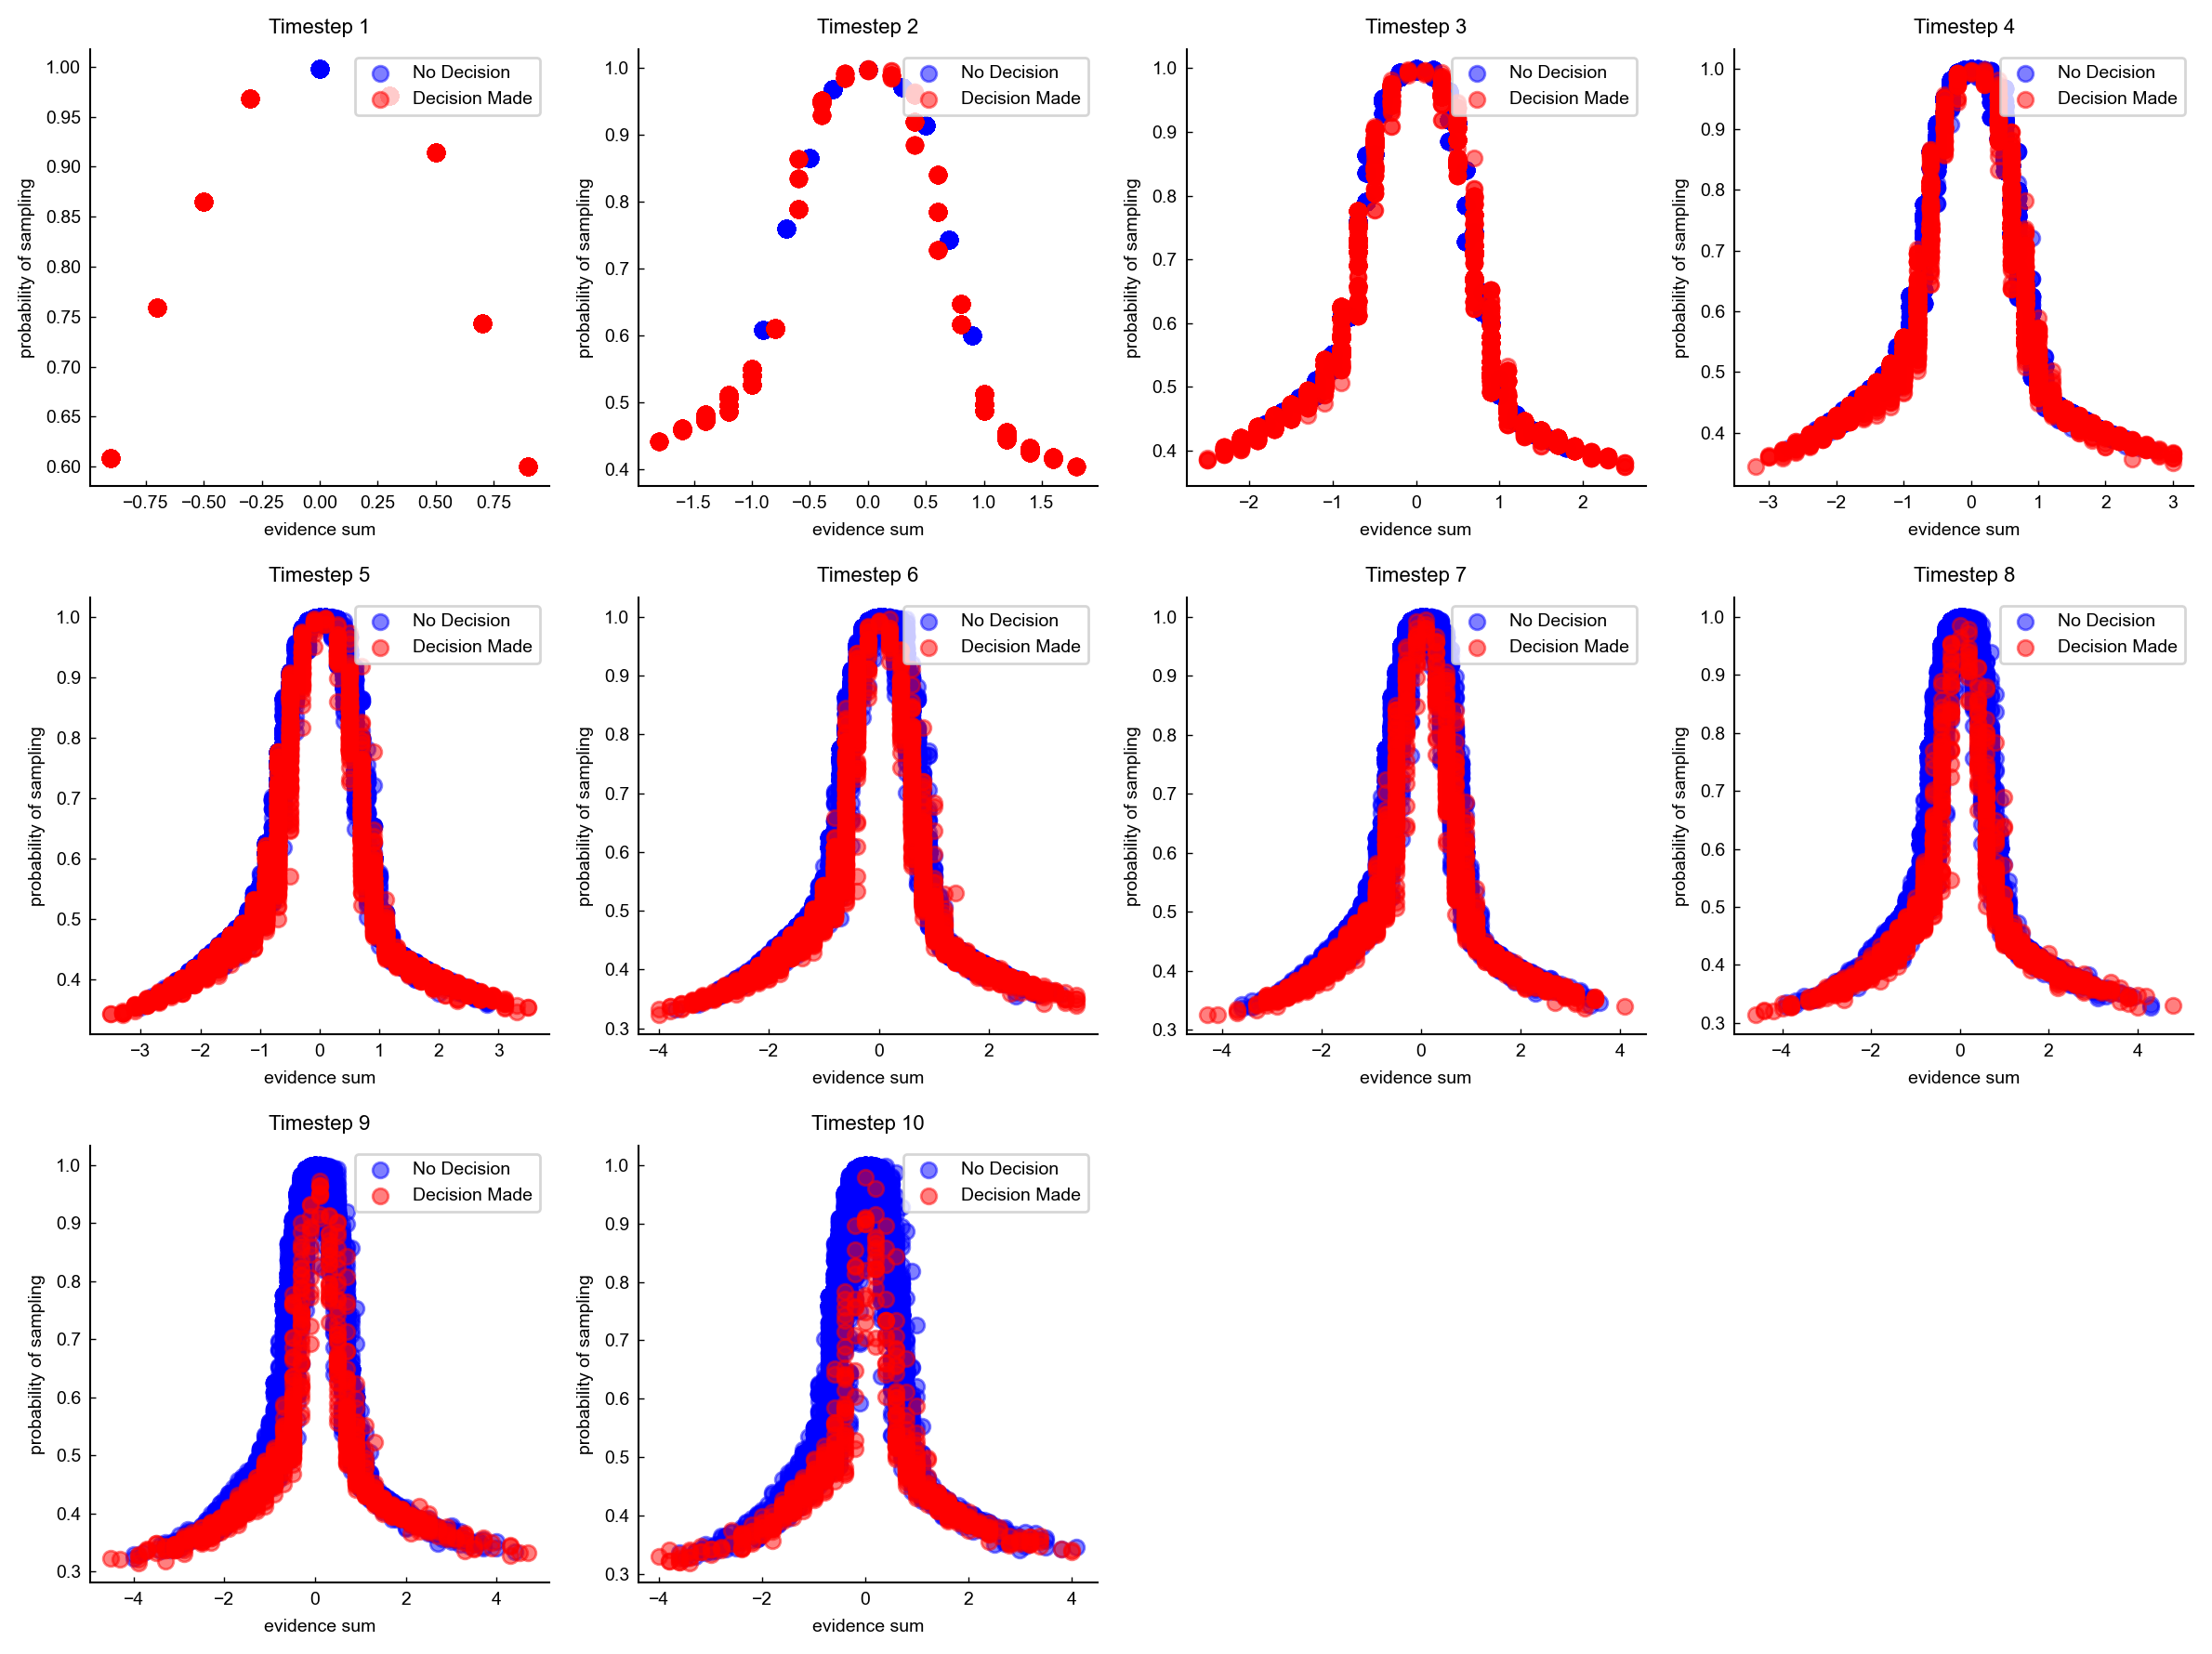

In [ ]:
max_timestep = 10
n_rows = int(np.ceil(max_timestep/4))
fig, axes = plt.subplots(n_rows, 4, figsize=(12, 3*n_rows))
axes = axes.flatten()

df["evidences"] = df.apply(lambda row: [target_log_ratios[s] for s in row["stimuli_so_far"][:row["decision_time"]]], axis=1)
df["evidence_sum"] = df["evidences"].apply(sum)

# Plot scatter for each timestep
for t in range(max_timestep):
    if t < len(axes):
        # Get data for this timestep
        mask = df['decision_time'] == t+1
        timestep_data = df[mask]
        
        # Create decision mask
        decision_mask = timestep_data['action'] < 2
        
        # Plot scatter points
        axes[t].scatter(timestep_data[~decision_mask]['evidence_sum'], 
                       timestep_data[~decision_mask]['p_sample'],
                       c='blue', alpha=0.5, label='No Decision')
        axes[t].scatter(timestep_data[decision_mask]['evidence_sum'],
                       timestep_data[decision_mask]['p_sample'], 
                       c='red', alpha=0.5, label='Decision Made')
        
        axes[t].set_title(f'Timestep {t+1}')
        axes[t].set_xlabel('evidence sum')
        axes[t].set_ylabel('probability of sampling')
        axes[t].legend()

# Remove empty subplots
for i in range(max_timestep, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()



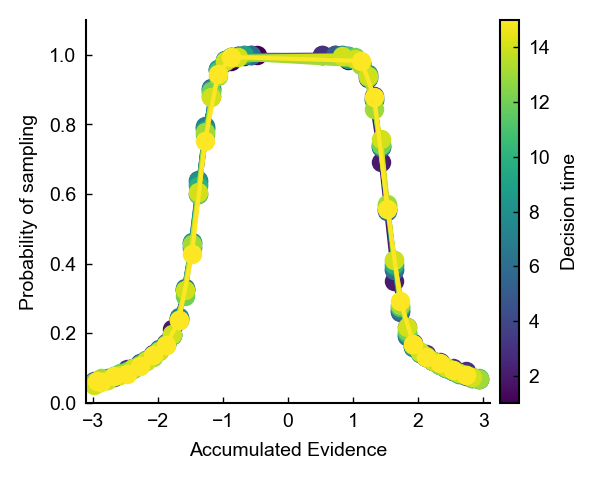

In [59]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

bin_width = 0.05
bin_start = -3
bin_end = 3.1

# only keep the rows that action is equal to correct_answer
df_decision = df_decision[df_decision['action'] == df_decision['correct_answer']]

df_decision["evidence_sum_bin"] = pd.cut(
    df_decision["evidence_sum"], 
    bins=np.arange(bin_start, bin_end, bin_width), 
    include_lowest=True
)


# n_bins = 33
# bin_edges = np.linspace(df['evidence_sum'].min(), df['evidence_sum'].max(), n_bins + 1)

# 2. 分箱并计算平均采样概率
# df['evidence_sum_bin'] = pd.cut(df['evidence_sum'], bins=bin_edges, include_lowest=True)
df_binned = (
    df_decision.dropna(subset=['evidence_sum_bin'])
      .groupby(['decision_time', 'evidence_sum_bin'], observed=True)['p_sample']
      .mean()
      .reset_index()
)
df_binned['bin_center'] = df_binned['evidence_sum_bin'].apply(lambda iv: iv.mid)

# 3. 配置 colormap
# dt_values = sorted(df_binned['decision_time'].unique())
dt_values = np.arange(1, 16)
cmap = cm.viridis
norm = Normalize(vmin=min(dt_values), vmax=max(dt_values))
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

df_binned['bin_center'] = df_binned['evidence_sum_bin'].apply(lambda iv: (iv.left + iv.right) / 2).astype(float)
df_binned = df_binned[df_binned['bin_center'].between(-3, 3)]
# df_binned = df_binned[df_binned['decision_time'] <= 15]

# 4. 绘图
fig, ax = plt.subplots(figsize=(3.10, 2.5))
for dt in dt_values:

    subset = df_binned[df_binned['decision_time'] == dt]
    ax.plot(subset['bin_center'],
            subset['p_sample'],
            marker='o',
            color=cmap(norm(dt)),
            label=f'dt={dt}')

ax.set_xlabel('Accumulated Evidence')
ax.set_ylabel('Probability of sampling')
# ax.set_title('Sampling Probability vs Cumulative Evidence by Decision Time')
ax.grid(False)
ax.set_xlim(-3.1, 3.1)
ax.set_ylim(0, 1.1)
ax.set_xticks(np.arange(-3, 4, 1))
# ax.set_aspect('equal', adjustable='box')

# 5. 添加 colorbar，指定 ax
cbar = fig.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label('Decision time')

# ax.legend(title='decision_time', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# plt.savefig('sampling_probability_vs_evidence_sum_softBound.svg', dpi=300)
plt.show()

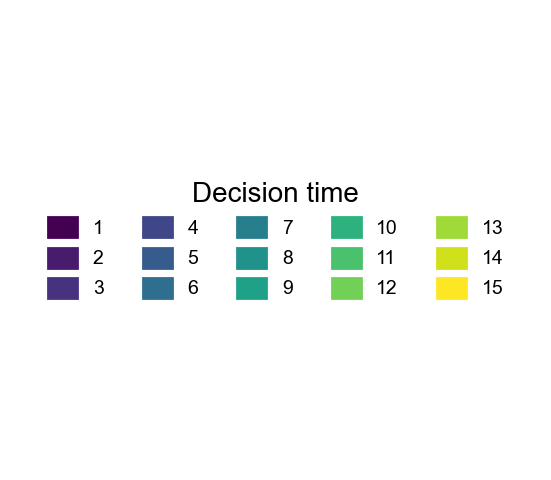

In [38]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
from matplotlib.colors import Normalize


# 决策时间值
dt_values = np.arange(1, 16)

# 设置 colormap 和归一化器
cmap = cm.viridis
norm = Normalize(vmin=min(dt_values), vmax=max(dt_values))

# 为每个 dt 创建一个 color patch
patches = [
    mpatches.Patch(color=cmap(norm(dt)), label=f'{dt}')
    for dt in dt_values
]

# 单独创建 legend 图
fig, ax = plt.subplots(figsize=(3, 2.5))
ax.axis('off')  # 不显示坐标轴

# 添加 legend，设置每行最多显示的标签数
legend = ax.legend(
    handles=patches,
    title='Decision time',
    loc='center',
    ncol=5,  # 每行 5 个标签，可调整
    frameon=False,
    handlelength=1.5,
    handleheight=1.2,
    borderpad=1.0
)

plt.tight_layout()
plt.savefig('legend_decision_time_discrete.svg', dpi=300)
plt.show()